# =========================================================
# 0️⃣ Setup & Imports
# =========================================================

In [1]:
import pandas as pd
import numpy as np
import os
from helpers import *
import warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
warnings.filterwarnings("ignore")

print("✅ Environment ready – helpers imported successfully.")

✅ Environment ready – helpers imported successfully.


# =========================================================
# 1️⃣ Data Loading & Splitting
# =========================================================

In [2]:
# =========================================================
# 1️⃣ Data Loading & Splitting
# =========================================================

# Folder path where all pickle files exist
data_folder = "DataNewPandas"

# File paths (inside the folder)
files = [
    os.path.join(data_folder, "df1_new.pkl"),
    os.path.join(data_folder, "df2_new.pkl"),
    os.path.join(data_folder, "df3_new.pkl"),
    os.path.join(data_folder, "df4_new.pkl"),
    os.path.join(data_folder, "df5_new.pkl")
]

# 👉 We'll use first 4 for training, last one for testing
train_files = files[:4]
test_files  = files[4:]

# Load and average training data
df_train = load_and_merge_training_data(train_files)

# Load test file (for unseen evaluation)
df_test_raw = pd.read_pickle(test_files[0])
df_test_raw = standardize_dataframe_columns(df_test_raw)

print(f"\n✅ Training data shape: {df_train.shape}")
print(f"✅ External test data shape: {df_test_raw.shape}")


✅ Loaded DataNewPandas\df1_new.pkl: (525164, 22)
✅ Loaded DataNewPandas\df2_new.pkl: (525164, 22)
✅ Loaded DataNewPandas\df3_new.pkl: (525164, 22)
✅ Loaded DataNewPandas\df4_new.pkl: (525164, 22)

✅ Averaged 4 files → Final shape: (525164, 23)

✅ Training data shape: (525164, 23)
✅ External test data shape: (528097, 23)


In [ ]:
# 💾 Save Averaged Training Data to CSV (for manual check)
df_train.to_csv("merged_train_avg.csv", index=False)
print("✅ Averaged training data saved successfully → merged_train_avg.csv")

In [3]:
# 🔧 Rename target column if needed
if "Control-PPC - Active power (1m)" in df_test_raw.columns:
    df_test_raw = df_test_raw.rename(columns={"Control-PPC - Active power (1m)": "active_power"})

print(f"✅ External test data shape: {df_test_raw.shape}")


✅ External test data shape: (528097, 23)


In [4]:
print(df_test_raw.columns.tolist())

['Time', 'Total Solar Irradiance on Inclined Plane POA1 (W/m2)', 'Total Solar Irradiance on Inclined Plane POA1 (Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA2 (W/m2)', 'Total Solar Irradiance on Inclined Plane POA2 (Wh/m2)', 'Total Solar Irradiance on Horizontal Plane GHI (W/m2)', 'Total Solar Irradiance on Horizontal Plane GHI (Wh/m2)', 'Ambient Temp. (degree centigrade)', 'Module Surface Temperature1 (degree centigrade)', 'Module Surface Temperature2 (degree centigrade)', 'Wind Speed (m/s)', 'Wind direction (degree)', 'Daily rain (mm)', 'Relative Humidity (%)', 'Soiling Loss Index Isc (%)', 'Soiling Loss Index Geff (%)', 'Isc Test (Amp)', 'Isc Ref (Amp)', 'Temperature Test (Deg C)', 'Temperature Reference Cell (Deg C)', 'Geff Test (W/m2)', 'Geff Reference (W/m2)', 'active_power']


In [4]:
if "Time" in df_test_raw.columns:
    df_test_raw = df_test_raw.rename(columns={"Time": "timestamp"})

# =========================================================
# 2️⃣ Data Cleaning
# =========================================================

In [5]:
SOLAR_PHYS_LIMITS = {
    # ☀️ Instantaneous Irradiance (W/m²)
    "Geff Reference (W/m2)": (0, 1400),
    "Geff Test (W/m2)": (0, 1400),
    "Total Solar Irradiance on Horizontal Plane GHI (W/m2)": (0, 1400),
    "Total Solar Irradiance on Inclined Plane POA1 (W/m2)": (0, 1400),
    "Total Solar Irradiance on Inclined Plane POA2 (W/m2)": (0, 1400),

    # 🔆 Cumulative Energy (Wh/m²)
    "Total Solar Irradiance on Horizontal Plane GHI (Wh/m2)": (0, 8000),
    "Total Solar Irradiance on Inclined Plane POA1 (Wh/m2)": (0, 8000),
    "Total Solar Irradiance on Inclined Plane POA2 (Wh/m2)": (0, 8000),

    # 🌡️ Temperatures 
    "Ambient Temp. (degree centigrade)": (-10, 60),
    "Temperature Test (Deg C)": (-20, 90),
    "Temperature Reference Cell (Deg C)": (-20, 90),
    "Module Surface Temperature1 (degree centigrade)": (-20, 90),
    "Module Surface Temperature2 (degree centigrade)": (-20, 90),

    # 💨 Wind 
    "Wind Speed (m/s)": (0, 30),
    "Wind direction (degree)": (0, 360),

    # 💧 Humidity / Rain
    "Relative Humidity (%)": (0, 100),
    "Daily rain (mm)": (0, 200),

    # ⚙️ Electrical / Soiling
    "Isc Ref (Amp)": (0, 20),
    "Isc Test (Amp)": (0, 20),
    "Soiling Loss Index Geff (%)": (0, 100),
    "Soiling Loss Index Isc (%)": (0, 100),
}


df_train_clean = clean_dataset(df_train, phys_limits=SOLAR_PHYS_LIMITS, mode="train")
df_test_clean  = clean_dataset(df_test_raw, phys_limits=SOLAR_PHYS_LIMITS, mode="test")

print(f"✅ Train shape: {df_train_clean.shape}")
print(f"✅ Test shape:  {df_test_clean.shape}")


⚙️ Replaced 259,331 negative active_power values with 0.
⚙️ Clipped 58,437 values in Geff Reference (W/m2) outside [0, 1400]
⚙️ Clipped 92,510 values in Geff Test (W/m2) outside [0, 1400]
⚙️ Clipped 1,003 values in Total Solar Irradiance on Horizontal Plane GHI (W/m2) outside [0, 1400]
⚙️ Clipped 1,003 values in Total Solar Irradiance on Inclined Plane POA1 (W/m2) outside [0, 1400]
⚙️ Clipped 1,003 values in Total Solar Irradiance on Inclined Plane POA2 (W/m2) outside [0, 1400]
⚙️ Clipped 22,386 values in Total Solar Irradiance on Horizontal Plane GHI (Wh/m2) outside [0, 8000]
⚙️ Clipped 98,105 values in Total Solar Irradiance on Inclined Plane POA1 (Wh/m2) outside [0, 8000]
⚙️ Clipped 98,365 values in Total Solar Irradiance on Inclined Plane POA2 (Wh/m2) outside [0, 8000]
⚙️ Clipped 1,006 values in Ambient Temp. (degree centigrade) outside [-10, 60]
⚙️ Clipped 1,994 values in Temperature Test (Deg C) outside [-20, 90]
⚙️ Clipped 1,994 values in Temperature Reference Cell (Deg C) outsi

In [7]:
print(df_train_clean.columns)
print(df_test_clean.columns)

Index(['timestamp', 'Ambient Temp. (degree centigrade)', 'Daily rain (mm)',
       'Geff Reference (W/m2)', 'Geff Test (W/m2)', 'Isc Ref (Amp)',
       'Isc Test (Amp)', 'Module Surface Temperature1 (degree centigrade)',
       'Module Surface Temperature2 (degree centigrade)',
       'Relative Humidity (%)', 'Soiling Loss Index Geff (%)',
       'Soiling Loss Index Isc (%)', 'Temperature Reference Cell (Deg C)',
       'Temperature Test (Deg C)',
       'Total Solar Irradiance on Horizontal Plane GHI (W/m2)',
       'Total Solar Irradiance on Horizontal Plane GHI (Wh/m2)',
       'Total Solar Irradiance on Inclined Plane POA1 (W/m2)',
       'Total Solar Irradiance on Inclined Plane POA1 (Wh/m2)',
       'Total Solar Irradiance on Inclined Plane POA2 (W/m2)',
       'Total Solar Irradiance on Inclined Plane POA2 (Wh/m2)',
       'Wind Speed (m/s)', 'Wind direction (degree)', 'active_power', 'hour'],
      dtype='object')
Index(['timestamp', 'Total Solar Irradiance on Inclined Plane PO

# =========================================================
# 3️⃣ Smart EDA (Redundancy Removal)
# =========================================================

In [6]:
df_train_smart, dropped_cols = smart_feature_dedup(df_train_clean, target="active_power", corr_thresh=0.99)
df_test_smart = df_test_clean[df_train_smart.columns.intersection(df_test_clean.columns)]

print(f"✅ After redundancy removal → Train shape: {df_train_smart.shape}")
print(f"🗑️ Dropped columns: {dropped_cols}")

🧠 Removed 8 redundant features (corr > 0.99)

🔍 Dropped pairs (top 10):
 - Geff Reference (W/m2) ↔ Geff Test (W/m2) | corr=0.9985 → dropped Geff Test (W/m2)
 - Isc Ref (Amp) ↔ Isc Test (Amp) | corr=0.9989 → dropped Isc Ref (Amp)
 - Isc Ref (Amp) ↔ Total Solar Irradiance on Inclined Plane POA1 (W/m2) | corr=0.9937 → dropped Isc Ref (Amp)
 - Isc Ref (Amp) ↔ Total Solar Irradiance on Inclined Plane POA2 (W/m2) | corr=0.9938 → dropped Isc Ref (Amp)
 - Isc Test (Amp) ↔ Total Solar Irradiance on Inclined Plane POA1 (W/m2) | corr=0.9937 → dropped Isc Test (Amp)
 - Isc Test (Amp) ↔ Total Solar Irradiance on Inclined Plane POA2 (W/m2) | corr=0.9937 → dropped Isc Test (Amp)
 - Module Surface Temperature1 (degree centigrade) ↔ Module Surface Temperature2 (degree centigrade) | corr=1.0000 → dropped Module Surface Temperature1 (degree centigrade)
 - Module Surface Temperature1 (degree centigrade) ↔ Temperature Reference Cell (Deg C) | corr=0.9942 → dropped Temperature Reference Cell (Deg C)
 - Modu

In [9]:
print(df_train_smart.columns)
print(df_test_smart.columns)

Index(['timestamp', 'Ambient Temp. (degree centigrade)', 'Daily rain (mm)',
       'Geff Reference (W/m2)', 'Relative Humidity (%)',
       'Soiling Loss Index Geff (%)', 'Soiling Loss Index Isc (%)',
       'Temperature Test (Deg C)',
       'Total Solar Irradiance on Horizontal Plane GHI (W/m2)',
       'Total Solar Irradiance on Horizontal Plane GHI (Wh/m2)',
       'Total Solar Irradiance on Inclined Plane POA1 (W/m2)',
       'Total Solar Irradiance on Inclined Plane POA2 (Wh/m2)',
       'Wind Speed (m/s)', 'Wind direction (degree)', 'active_power', 'hour'],
      dtype='object')
Index(['timestamp', 'Ambient Temp. (degree centigrade)', 'Daily rain (mm)',
       'Geff Reference (W/m2)', 'Relative Humidity (%)',
       'Soiling Loss Index Geff (%)', 'Soiling Loss Index Isc (%)',
       'Temperature Test (Deg C)',
       'Total Solar Irradiance on Horizontal Plane GHI (W/m2)',
       'Total Solar Irradiance on Horizontal Plane GHI (Wh/m2)',
       'Total Solar Irradiance on Inclined

In [7]:
drop_cols = [
    "Total Solar Irradiance on Horizontal Plane GHI (Wh/m2)",
    "Total Solar Irradiance on Inclined Plane POA2 (Wh/m2)"
]

df_train_filtered = df_train_smart.drop(columns=drop_cols, errors="ignore")
df_test_filtered  = df_test_smart.drop(columns=drop_cols, errors="ignore")

print("✅ Columns after filtering:")
print(df_train_filtered.columns.tolist())


✅ Columns after filtering:
['timestamp', 'Ambient Temp. (degree centigrade)', 'Daily rain (mm)', 'Geff Reference (W/m2)', 'Relative Humidity (%)', 'Soiling Loss Index Geff (%)', 'Soiling Loss Index Isc (%)', 'Temperature Test (Deg C)', 'Total Solar Irradiance on Horizontal Plane GHI (W/m2)', 'Total Solar Irradiance on Inclined Plane POA1 (W/m2)', 'Wind Speed (m/s)', 'Wind direction (degree)', 'active_power', 'hour']


# =========================================================
# 4️⃣ Feature Selection (PCC, MI, Spearman, Jaccard)
# =========================================================

📊 Spearman correlation (PCC vs MI ranks): 0.685
🧩 Jaccard similarity (top-10 sets): 0.818


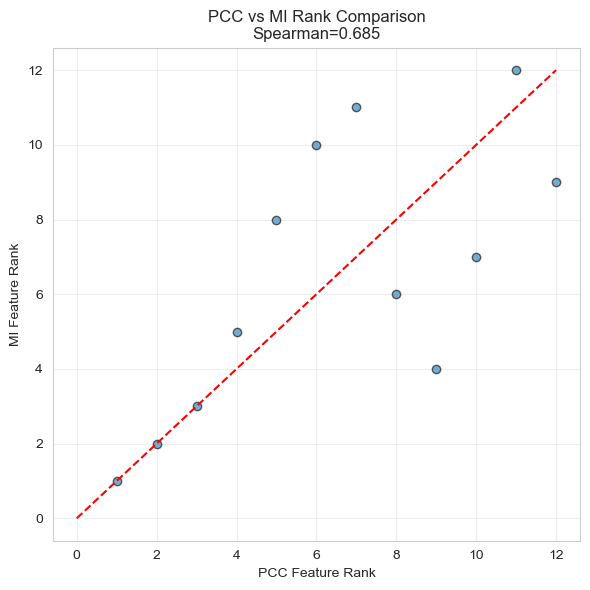


🔹 Top features (PCC): ['Total Solar Irradiance on Inclined Plane POA1 (W/m2)', 'Total Solar Irradiance on Horizontal Plane GHI (W/m2)', 'Geff Reference (W/m2)', 'Temperature Test (Deg C)', 'Ambient Temp. (degree centigrade)', 'Wind Speed (m/s)', 'Wind direction (degree)', 'Soiling Loss Index Isc (%)', 'hour', 'Soiling Loss Index Geff (%)']
🔹 Top features (MI): ['Total Solar Irradiance on Inclined Plane POA1 (W/m2)', 'Total Solar Irradiance on Horizontal Plane GHI (W/m2)', 'Geff Reference (W/m2)', 'hour', 'Temperature Test (Deg C)', 'Soiling Loss Index Isc (%)', 'Soiling Loss Index Geff (%)', 'Ambient Temp. (degree centigrade)', 'Relative Humidity (%)', 'Wind Speed (m/s)']

📊 Spearman correlation: 0.685
🧩 Jaccard similarity: 0.818


In [8]:
top_pcc, top_mi, rho, jaccard = select_features(df_train_filtered, target="active_power", top_k=10)

print("\n🔹 Top features (PCC):", top_pcc)
print("🔹 Top features (MI):", top_mi)
print(f"\n📊 Spearman correlation: {rho:.3f}")
print(f"🧩 Jaccard similarity: {jaccard:.3f}")


# =========================================================
# 5️⃣ Dataset Preparation for Modeling
# =========================================================

In [9]:
# Using top MI features (based on your previous project decision)
df_mi = df_train_filtered[top_mi + ["active_power"]].copy()

# Add timestamp-based grouping features (for seasonal CV)
if "timestamp" in df_train_filtered.columns:
    df_mi["timestamp"] = pd.to_datetime(df_train_filtered["timestamp"], errors="coerce")
else:
    df_mi["timestamp"] = pd.Timestamp.now()

df_mi["month"] = df_mi["timestamp"].dt.month
df_mi["season"] = df_mi["month"].map({
    12:"winter", 1:"winter", 2:"winter",
    3:"spring", 4:"spring", 5:"spring",
    6:"summer", 7:"summer", 8:"summer",
    9:"fall", 10:"fall", 11:"fall"
})

# Split features / target / groups
X = df_mi.drop(columns=["active_power", "timestamp", "season"])
y = df_mi["active_power"]
groups = df_mi["season"]

print(f"✅ Final modeling dataset shape: {X.shape}")


✅ Final modeling dataset shape: (525164, 11)


In [13]:
print(X.columns.tolist())

['Total Solar Irradiance on Inclined Plane POA1 (W/m2)', 'Total Solar Irradiance on Horizontal Plane GHI (W/m2)', 'Geff Reference (W/m2)', 'hour', 'Temperature Test (Deg C)', 'Soiling Loss Index Isc (%)', 'Soiling Loss Index Geff (%)', 'Ambient Temp. (degree centigrade)', 'Relative Humidity (%)', 'Wind Speed (m/s)', 'month']


# =========================================================
# 6️⃣ Hyperparameter Tuning (Poly1 / Poly2 / XGBoost)
# =========================================================

In [10]:
models_with_params = {
    "Poly1": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(1, include_bias=False)),
            ("ridge", Ridge())
        ]),
        {"ridge__alpha": [0.1, 1.0, 10.0]}
    ),
    "Poly2": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(2, include_bias=False)),
            ("ridge", Ridge(max_iter=10000))
        ]),
        {"ridge__alpha": [0.1, 1.0, 10.0]}
    ),
    "XGBoost": (
        XGBRegressor(random_state=42, n_jobs=-1),
        {
            "n_estimators": [400, 600],
            "max_depth": [3, 4],
            "learning_rate": [0.02, 0.03],
            "min_child_weight": [5, 8],
            "reg_lambda": [5.0, 8.0],
            "subsample": [0.8],
            "colsample_bytree": [0.7],
            "gamma": [0, 0.2]
        }
    )
}

grids = run_multiple_gridsearches(models_with_params, X, y, groups)


🚀 Running GridSearchCV for Poly1 ...
Fitting 4 folds for each of 3 candidates, totalling 12 fits
✅ Best params for Poly1: {'ridge__alpha': 10.0}
🏆 Best CV RMSE (balanced): 14526.70

🚀 Running GridSearchCV for Poly2 ...
Fitting 4 folds for each of 3 candidates, totalling 12 fits
✅ Best params for Poly2: {'ridge__alpha': 10.0}
🏆 Best CV RMSE (balanced): 11180.56

🚀 Running GridSearchCV for XGBoost ...
Fitting 4 folds for each of 64 candidates, totalling 256 fits
✅ Best params for XGBoost: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 600, 'reg_lambda': 8.0, 'subsample': 0.8}
🏆 Best CV RMSE (balanced): 10450.39


# =========================================================
# 7️⃣ Evaluate All Tuned Models
# =========================================================


################ EVALUATION for Poly1 #################
[Poly1] WINTER: Train RMSE=14,266.45, Test RMSE=20,611.54 | Train R²=0.9864, Test R²=0.9780
[Poly1] SPRING: Train RMSE=16,669.40, Test RMSE=11,586.47 | Train R²=0.9836, Test R²=0.9906
[Poly1] SUMMER: Train RMSE=15,810.84, Test RMSE=16,365.48 | Train R²=0.9841, Test R²=0.9850
[Poly1] FALL: Train RMSE=13,846.35, Test RMSE=21,164.68 | Train R²=0.9890, Test R²=0.9624

[Poly1] AVG → Train RMSE=15,148.26 | Test RMSE=17,432.04 | Train R²=0.9858 | Test R²=0.9790

################ EVALUATION for Poly2 #################
[Poly2] WINTER: Train RMSE=10,289.26, Test RMSE=14,677.01 | Train R²=0.9929, Test R²=0.9888
[Poly2] SPRING: Train RMSE=12,242.09, Test RMSE=8,513.42 | Train R²=0.9911, Test R²=0.9949
[Poly2] SUMMER: Train RMSE=11,838.70, Test RMSE=13,219.81 | Train R²=0.9911, Test R²=0.9902
[Poly2] FALL: Train RMSE=10,136.33, Test RMSE=17,256.47 | Train R²=0.9941, Test R²=0.9750

[Poly2] AVG → Train RMSE=11,126.59 | Test RMSE=13,416.68 | Tr

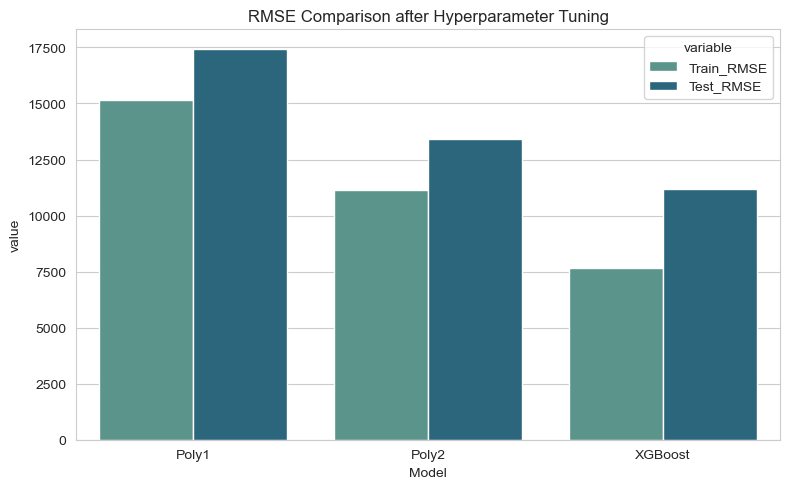

In [11]:
season_labels = ["WINTER", "SPRING", "SUMMER", "FALL"]

evals = {
    name: evaluate_best_model(grid, X, y, groups, name, group_labels=season_labels)
    for name, grid in grids.items()
}

summary = compare_models_results(evals)


# =========================================================
# 8️⃣ Train Final XGBoost Model
# =========================================================

✅ XGBoost model trained successfully!
💾 Model saved → final_xgb_model.pkl


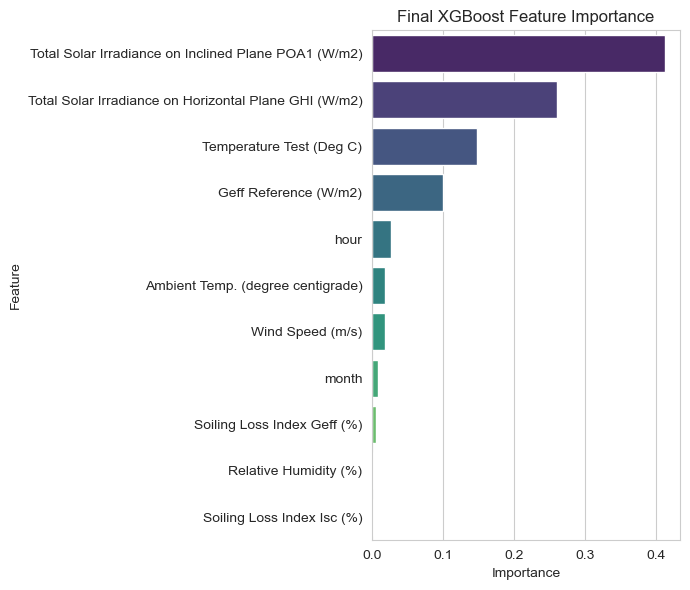

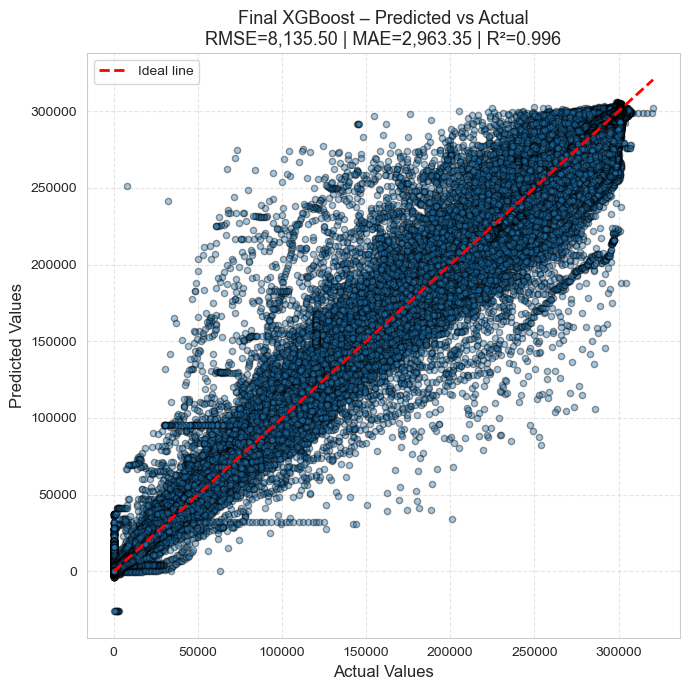

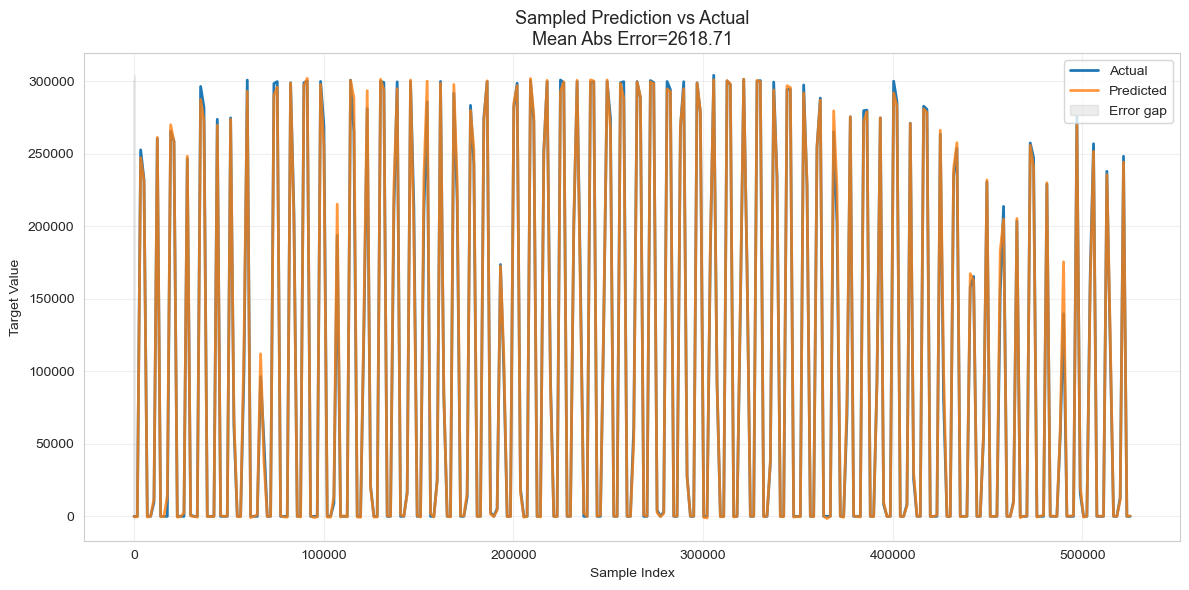

🔍 Sample numeric comparison (first 10 rows):
       Actual      Predicted  Difference
0       0.000    -152.343002    -152.343
1       0.000    -306.036987    -306.037
2  252732.670  247353.843750   -5378.826
3  232251.950  231079.531250   -1172.419
4       0.000    -452.821991    -452.822
5       0.000     143.759003     143.759
6    9801.414   12168.466797    2367.053
7  260535.610  261314.703125     779.093
8       0.000    -148.031006    -148.031
9       0.000    -136.470993    -136.471
{'RMSE': 8135.503049623174, 'R2': 0.9959398906233701}


In [12]:
custom_params = {
    'colsample_bytree': 0.7,
    'gamma': 0,
    'learning_rate': 0.02,
    'max_depth': 4,
    'min_child_weight': 5,
    'n_estimators': 600,
    'subsample': 0.8,
    'reg_lambda': 8.0,
    'reg_alpha': 1.0,        
    'random_state': 42,     
    'n_jobs': -1             
}

final_xgb = train_xgb_model(X, y, params=custom_params)
save_model(final_xgb, "final_xgb_model.pkl")

plot_feature_importance(final_xgb, X, "Final XGBoost Feature Importance")
metrics = plot_predictions_vs_actual(final_xgb, X, y, "Final XGBoost – Predicted vs Actual", sample_size=300)
print(metrics)


# =========================================================
# 9️⃣ External Test Evaluation (Unseen File)
# =========================================================

In [15]:
df_test_ready.isna().sum()

timestamp                                                   0
Ambient Temp. (degree centigrade)                        2351
Daily rain (mm)                                          2351
Geff Reference (W/m2)                                    1993
Relative Humidity (%)                                    2351
Soiling Loss Index Geff (%)                              1993
Soiling Loss Index Isc (%)                               1993
Temperature Test (Deg C)                                 1993
Total Solar Irradiance on Horizontal Plane GHI (W/m2)    2351
Total Solar Irradiance on Inclined Plane POA1 (W/m2)     2351
Wind Speed (m/s)                                         2351
Wind direction (degree)                                  2351
active_power                                             1390
hour                                                        0
month                                                       0
dtype: int64

In [18]:
print((df_test_filtered['active_power'] == 0 ).sum())

260827


📦 External Test RMSE: 15,935.46
📈 External Test R²: 0.9845


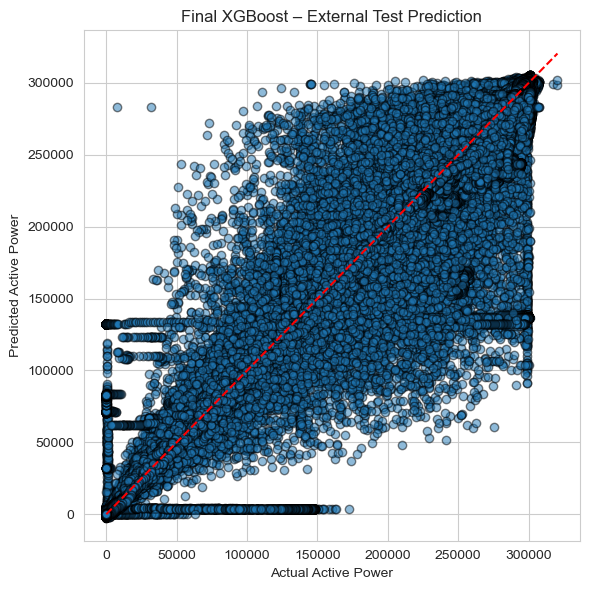

In [16]:
# Prepare test data
df_test_ready = df_test_filtered.copy()
df_test_ready = df_test_ready.fillna(method="ffill").fillna(method="bfill")

# Add month (to match training features)
df_test_ready["timestamp"] = pd.to_datetime(df_test_ready["timestamp"], errors="coerce")
df_test_ready["month"] = df_test_ready["timestamp"].dt.month

# Match columns
X_test = df_test_ready[X.columns.intersection(df_test_ready.columns)].copy()
y_test = df_test_ready["active_power"]

# Predict
y_pred = final_xgb.predict(X_test)

# Evaluate
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print(f"📦 External Test RMSE: {rmse_test:,.2f}")
print(f"📈 External Test R²: {r2_test:.4f}")

# Plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Active Power")
plt.ylabel("Predicted Active Power")
plt.title("Final XGBoost – External Test Prediction")
plt.tight_layout()
plt.show()


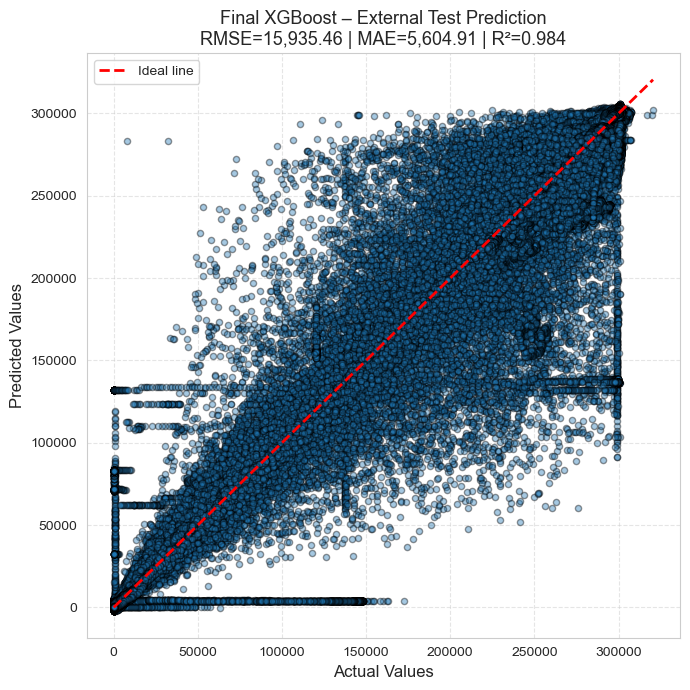

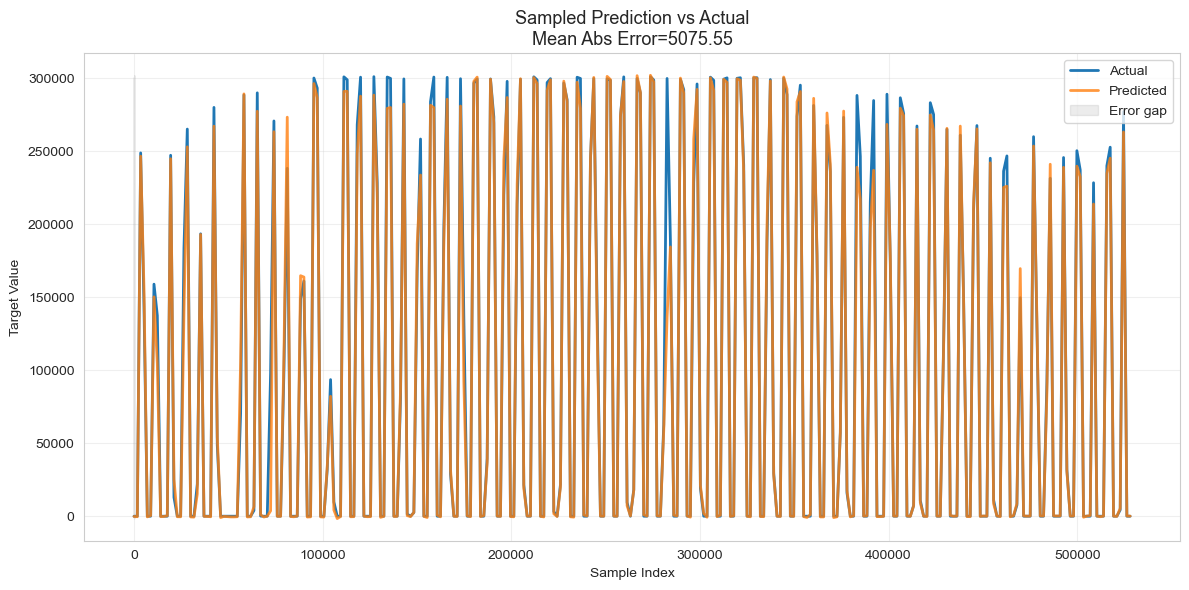

🔍 Sample numeric comparison (first 10 rows):
       Actual      Predicted  Difference
0       0.000    -152.343002    -152.343
1       0.000    -343.967010    -343.967
2  248860.230  246649.296875   -2210.933
3  143869.830  156016.593750   12146.764
4       0.000    -447.619995    -447.620
5       0.000     387.350006     387.350
6  158952.750  150264.828125   -8687.922
7  137454.339  104470.898438  -32983.440
8       0.000    -303.947998    -303.948
9       0.000    -154.774002    -154.774

📊 Test Performance Metrics:
{'RMSE': 15935.464916160314, 'R2': 0.9844524476471989}


In [22]:
metrics_test = plot_predictions_vs_actual(
    final_xgb, 
    X_test, 
    y_test, 
    title="Final XGBoost – External Test Prediction", 
    sample_size=300
)

print("\n📊 Test Performance Metrics:")
print(metrics_test)


# =========================================================
# 1️⃣0️⃣ Evaluate RMSE vs System Capacity
# =========================================================

In [20]:
# Use training data (or MI dataset) for capacity estimation
rmse_cv_avg = summary.loc[summary["Model"]=="XGBoost", "Test_RMSE"].values[0]

rmse_season = {
    "summer": 7830.05,
    "fall": 14061.02,
    "spring": 10106.61,
    "winter": 12788.48
}

# Evaluate RMSE % on training dataset
cap_results_train = evaluate_rmse_against_capacity(df_mi, rmse_season)

# Evaluate RMSE % on external test dataset
rmse_test_final = np.sqrt(mean_squared_error(y_test, y_pred))
cap_results_test = evaluate_rmse_against_capacity(df_test_ready, rmse_test_final)

print("\n🏁 Summary:")
print(f"System capacity estimate: {cap_results_train['capacity_est']:.0f} W")
print(f"Train RMSE% of capacity: {cap_results_train['rmse_percent']:.2f}%")
print(f"Test RMSE% of capacity:  {cap_results_test['rmse_percent']:.2f}%")


🔎 Capacity estimation (Watts):
 - P99.0  : 301,549
 - P99.5  : 303,709
 - Median of top-100: 306,318

✅ Chosen capacity estimate: 303,709 W

📏 RMSE as % of capacity:
 - Summer : 2.58%
 - Fall   : 4.63%
 - Spring : 3.33%
 - Winter : 4.21%
 - Overall: 3.69%
🔎 Capacity estimation (Watts):
 - P99.0  : 301,600
 - P99.5  : 303,721
 - Median of top-100: 306,306

✅ Chosen capacity estimate: 303,721 W

📏 RMSE as % of capacity:
 - Overall RMSE (15,935.46) → 5.25%

🏁 Summary:
System capacity estimate: 303709 W
Train RMSE% of capacity: 3.69%
Test RMSE% of capacity:  5.25%
